<h2>ToDo</h2>
<ul>
    <li>allow smooth running of 
        <ul>
            <li>empirical data from excel</li>
            <li>empirical data from mat-file</li>
            <li>artificially generated data</li>
        </ul>
    </li>
    <li>display results for each network on axis gamma vs delta (with nu_max as color?)</li>
    <li>fix widges plotting</li>
    <li>allow plotting of distributions, given values of gamma,delta,nu_max (maybe with widges)</li>
    <li>ask for estimate of layer borders (current density estimate) and implement</li>
    <li>check, whether additive model makes sense (and whether hierarchical inference is even in here?!)</li>
    <li>obtain biological parameters from inference</li>   
    <li>migrate notebook to shared notebook, or find some other good way to work on it collaboratively</li>
    <li>migrate code to python code and change notebook to accessing the "API" only</li>
    <li>include fraction of silent neurons (~70% in CTKO, ~30% in WT, all exc, not much data in inhib)</li>
    <li>pooling across hemispheres seems "ok"</li>
    <li>run inference without layers -> any effect between WT and cTKO?</li>
    <li>find if there is an effect on NMDA (ratio, timeconstant. ...)</li>
    <li>implement slicing data along up/down states</li>
    
</ul>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.io as sio
import os, sys

In [2]:
import pandas as pd

root_dir = os.path.dirname(os.path.abspath(''))
if not root_dir in sys.path: sys.path.append(root_dir)
from empirical.read_data import *

<h1>Data preprocessing</h1>
<p>Data can be read in from three different sources by according functions:
<ul>
    <li><code>xlsx_data</code>: empirical data from excel</li>
    <li><code>mat_data</code>: empirical data from mat-file</li>
    <li><code>artificial_data</code>: artificially generated data</li>
</ul>
The final data will contain a multi-dimensional array of firing rates with the format:
<pre>[animal type X number animals X number layers X number clusters X number neurons]</pre>
</p>

In [4]:
#from create_measures import *

class ModelParams:
    
    def __init__(self,mode,**kwargs):
        
        if mode=='empirical':
            
            filePath = kwargs['filePath']
            ext = os.path.splitext(filePath)[1]
            if ext=='.mat':
                self.mat_data(filePath)
            elif ext=='.xlsx':
                self.xlsx_data(filePath,sheet=kwargs['sheet'])
        if mode=='artificial':
            self.artificial_data(filePath)
            
        pass
    
    def mat_data(self, filePath='../../data/BuscheLab/spiking_data_for_modeling_with_depth.mat'):
        
        data = read_data(filePath=filePath,plot=False)
        self._num_types = 2
        self._num_layers = 3
        self._num_clusters = 2
                    
        animal_idx = np.zeros(self._num_types,'int')
        
        self.modelShape = (self._num_types,0,self._num_layers,self._num_clusters)
        
        self.spikes = np.zeros(self.modelShape + (0,))
        spikes_shape = self.spikes.shape
        for d_idx,sd in enumerate(data):
            
            type_idx = 0 if sd["classification"]["spikes_genotype"][1]==114 else 1 # 0='WT', 1='cTKO'
            animal_idx[type_idx] = animal_idx[type_idx]+1
            
            if max(animal_idx)>self.spikes.shape[1]:
                self.spikes = np.pad(self.spikes,((0,0),(0,1),(0,0),(0,0),(0,0)),'constant',constant_values=np.NaN)
            
            for layer_idx in range(self._num_layers):
                
                for cluster_idx in range(self._num_clusters):
                    
                    idx = (np.array(sd['layer'])==layer_idx) & (sd['cluster_idx']-1==cluster_idx)
                    nSpikes = idx.sum()
                    if nSpikes > spikes_shape[-1]:
                        self.spikes = np.pad(self.spikes,((0,0),(0,0),(0,0),(0,0),(0,nSpikes-spikes_shape[-1])),'constant',constant_values=np.NaN)
                        spikes_shape = self.spikes.shape
                    
                    self.spikes[type_idx,animal_idx[type_idx]-1,layer_idx,cluster_idx,:nSpikes] = sd['rate'][idx,0]
        
        self._num_animals = self.spikes.shape[1]
        self.nMax = spikes_shape[-1]
        
        self.spikes = np.transpose(self.spikes,(4,0,1,2,3))
        print(self.spikes.shape)
        self.mask = ~np.isnan(self.spikes)
        self.spikes = self.spikes[self.mask]
        print(self.spikes)
        #self.spikes = self.spikes.flatten()
    
    def xlsx_data(self, filePath='../../data/BuscheLab/2P_data.xlsx',sheet=None):
        
        self._num_layers = 1
        self._num_clusters = 1
        
        data = pd.ExcelFile(fileName)
        self.spikes = pd.read_excel(fileName,sheet_name=sheet)
        self.spikes = self.spikes.to_numpy()
        print(self.spikes.shape)
        
        self._num_animals = self.spikes.shape[1]
        self._num_layers = 1
        self._num_clusters = 1
        self.modelShape = (self._num_animals,self._num_layers,self._num_clusters)
        
        self.nMax = self.spikes.shape[0]
        self.spikes = self.spikes.reshape((self.nMax,) + self.modelShape)
        print(self.spikes.shape)
        print(self.spikes)
        self.mask = ~np.isnan(self.spikes)
        self.spikes = self.spikes[self.mask]
        
        #print(self.spikes)
        #dfs = {sheet_name: data.parse(sheet_name) 
        #  for sheet_name in data.sheet_names}
        #print(dfs)
    
    def artificical_data(self,):
        
        self._num_layers = 1
        self._num_clusters = 2
        
        arr_rateWnt = [1.,2.,5.]
        arr_alpha_0 = [0.0,0.02,0.06]
        
        for L in range(arr_rateWnt):
            res = create_measures(L=1,S=[1,2],N=100,rerun=True,rateWnt=1.,alpha_0=0.02)
                    

#exp_data = spike_data#[:10]
mP = ModelParams('empirical',filePath='../../data/BuscheLab/spiking_data_for_modeling_with_depth.mat')
#mP.mat_data()
#mP.CA2p_data(sheet='WT')

0 -1000 -250 779
1 -250 200 535
2 200 1000 101
(53, 2, 10, 3, 2)
[ 4.19000815  0.29000056  4.6800091   5.19001009  1.78004035  0.79835143
  0.22000499  0.23667203  0.36667498  4.94992556  6.62046292  0.29176052
  3.20269687  0.33177339  0.53166944  0.39166871  6.45670038  0.21166777
  0.59166976  0.21000365  6.60178146 10.2285112   4.11041127  2.32023215
  4.14041427  0.4333767   0.59783717  2.98918583  0.38074546  0.86335702
  0.16532369  0.35068661  0.76065478  0.5612761   4.70130999  0.18685121
  1.08440436  0.19185616  0.17168403  0.32003236  0.27336097  0.31836552
  1.09002319  1.43003043  0.27668457  0.23501521  0.38669169  0.1733509
  2.14521738  0.33167767  0.32167734  4.52681681  0.76169193  0.45001365
  0.60835179  0.42167946  0.19500592  8.24525011  2.70341534  0.49838339
  1.9801989   0.27336079  0.49004922  0.23168994  1.21842668  0.61338033
  4.42867262  2.29350904  6.83492093  1.06191333  0.60347351  0.21004879
 14.07326891  0.76166815  1.33000259  2.63667179  4.78010835

In [60]:
mP._num_animals

10

In [ ]:
import ipywidgets as widgets

In [5]:
widgets.FloatRangeSlider(0,1,100)

NameError: name 'widgets' is not defined

In [7]:
print(mP.spikes.shape)

mP.spikes
mP.modelShape
mP.spikes

(585,)


array([ 4.19000815,  0.29000056,  4.6800091 ,  5.19001009,  1.78004035,
        0.79835143,  0.22000499,  0.23667203,  0.36667498,  4.94992556,
        6.62046292,  0.29176052,  3.20269687,  0.33177339,  0.53166944,
        0.39166871,  6.45670038,  0.21166777,  0.59166976,  0.21000365,
        6.60178146, 10.2285112 ,  4.11041127,  2.32023215,  4.14041427,
        0.4333767 ,  0.59783717,  2.98918583,  0.38074546,  0.86335702,
        0.16532369,  0.35068661,  0.76065478,  0.5612761 ,  4.70130999,
        0.18685121,  1.08440436,  0.19185616,  0.17168403,  0.32003236,
        0.27336097,  0.31836552,  1.09002319,  1.43003043,  0.27668457,
        0.23501521,  0.38669169,  0.1733509 ,  2.14521738,  0.33167767,
        0.32167734,  4.52681681,  0.76169193,  0.45001365,  0.60835179,
        0.42167946,  0.19500592,  8.24525011,  2.70341534,  0.49838339,
        1.9801989 ,  0.27336079,  0.49004922,  0.23168994,  1.21842668,
        0.61338033,  4.42867262,  2.29350904,  6.83492093,  1.06

In [8]:
a = np.random.rand(3,4,2)
b = np.tile(a,(5,1,1,1))
b.shape

(5, 3, 4, 2)

In [5]:
def construct_model(name,mP,sigma_type=1.0,sigma_animal=0.2,sigma_layer=1.0,sigma_cluster=1.0):
    
    ## build gamma as a base value + modifications per layer and per animal
    # gamma = gamma_base + delta_gamma_layer (N(0,sigma_layer)) + delta_gamma_animal (N(0,sigma_animal))
    
    sigma_base = pm.HalfNormal(f'sigma_{name}',sigma=1.);
    #gamma_base = pm.HalfNormal('gamma_base',sigma=sigma_gamma_base,shape=(mP._num_animals,mP._num_layers,2));
    base = pm.HalfNormal(f'{name}_base',sigma=sigma_base);
    
    delta_type = pm.Normal(f'delta_{name}_type',mu=0,sigma=sigma_type,shape=(mP._num_types,1,1,1))
    delta_animal = pm.Normal(f'delta_{name}_animal',mu=0,sigma=sigma_animal, shape=(1,mP._num_animals,1,1))
    delta_layer = pm.Normal(f'delta_{name}_layer',mu=0,sigma=sigma_layer, shape=(1,1,mP._num_layers,1))
    delta_cluster = pm.Normal(f'delta_{name}_cluster',mu=0,sigma=sigma_cluster, shape=(1,1,1,mP._num_clusters))
    
    var = base + delta_type + delta_cluster + delta_layer + delta_animal
    pm.Deterministic(name,var)    
    
    var = tt.tile(var,(mP.nMax,1,1,1,1),5)
    tt.printing.Print(f'{name} shape')(tt.shape(var))
    
    var = var[mP.mask]
        
    return var

<h1>Model definition</h1>

In [6]:
import pymc3 as pm
import arviz as az
import theano.tensor as tt

with pm.Model() as model:
    # replace normals with student-t distributions
    
    gamma = construct_model('gamma',mP);
    delta = construct_model('delta',mP);
    
    mu_nu_max = pm.Normal('mu_nu_max',mu=20.,sigma=5.);
    sigma_nu_max = pm.Normal('sigma_nu_max',mu=5.,sigma=2.);
    
    # define nu_max as being able to differ between layers and clusters, but not animals
    nu_max = pm.Normal('nu_max',mu=mu_nu_max,sigma=sigma_nu_max,shape=(mP._num_layers,mP._num_clusters));
    nu_max = tt.tile(nu_max,(mP.nMax,mP._num_types,mP._num_animals,1,1),5)
    tt.printing.Print('nu')(tt.shape(nu_max))
    nu_max = nu_max[mP.mask]
    
    
    def likelihood(spike_data):
        
        # introduce checks for consistency, etc
        scaled_NU = tt.log(spike_data / nu_max)
        logP = - tt.log( nu_max / gamma * tt.sqrt( -np.pi * scaled_NU ) ) - delta**2 / 2 + \
            ( gamma**2 - 1 ) * scaled_NU + \
            tt.log( tt.cosh( gamma * delta * tt.sqrt( -2 * scaled_NU ) ) )
        
        # penalize nan-entries (e.g. when log is negative, etc)
        logP = tt.switch(tt.isnan(logP), -10000., logP)

        return tt.sum(logP)
        
    ## watch out: for some reason, NaNs in observed data are converted to 0s
    logP = pm.DensityDist('logP',likelihood,observed=mP.spikes)
                   
    trace = pm.sample(
        init='adapt_diag',
        chains=4,draws=4000,tune=2000,
        target_accept=0.8,
        return_inferencedata=True)

gamma shape __str__ = [53  2 10  3  2]
delta shape __str__ = [53  2 10  3  2]
nu __str__ = [53  2 10  3  2]


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_max, sigma_nu_max, mu_nu_max, delta_delta_cluster, delta_delta_layer, delta_delta_animal, delta_delta_type, delta_base, sigma_delta, delta_gamma_cluster, delta_gamma_layer, delta_gamma_animal, delta_gamma_type, gamma_base, sigma_gamma]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 411 seconds.
There were 2271 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2949 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5669874938042839, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2848 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7033665291279144, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2215 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [8]:
trace.to_netcdf('results_trace.nc')

'results_trace.nc'

In [9]:
trace.to_zarr('results_trace.zarr')

ImportError: 'to_zarr' method needs Zarr (2.5.0+) installed.

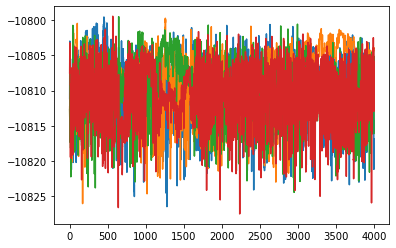

In [10]:
for i in range(4):
    plt.plot(trace.log_likelihood['logP'][i,:,0])


<h1>Display results</h1>

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

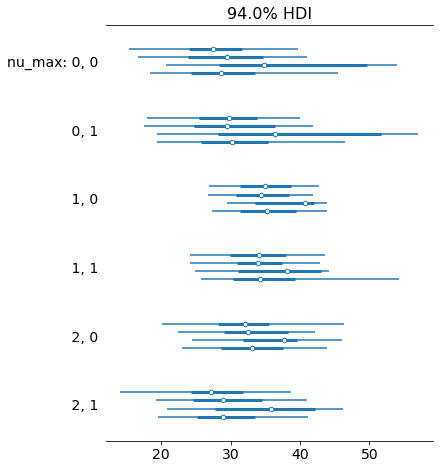

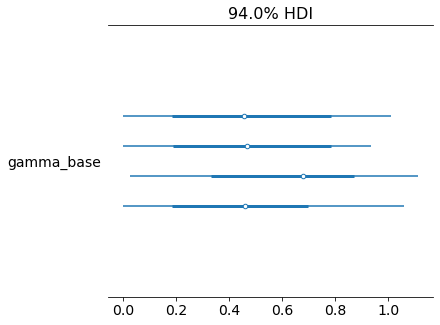

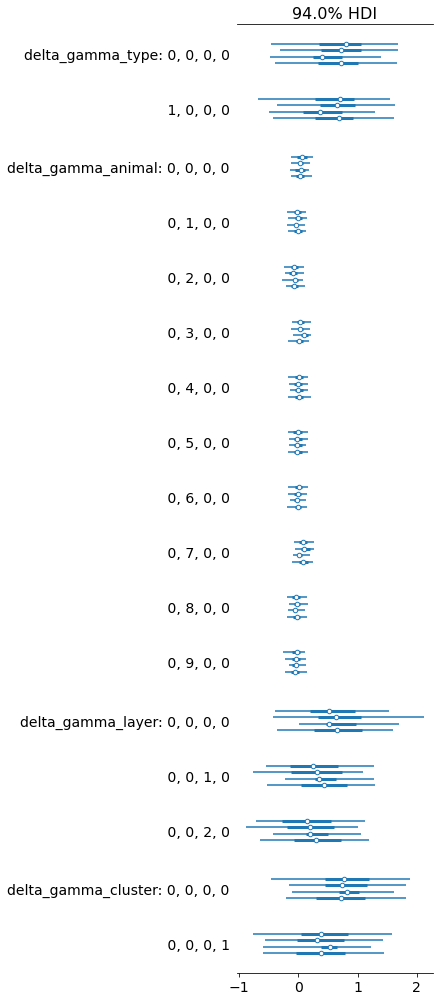

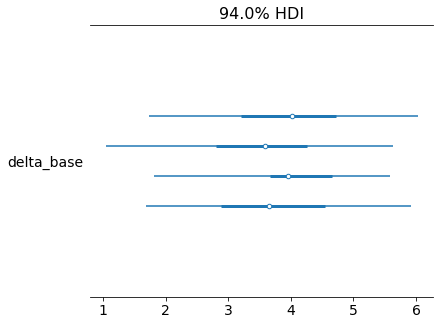

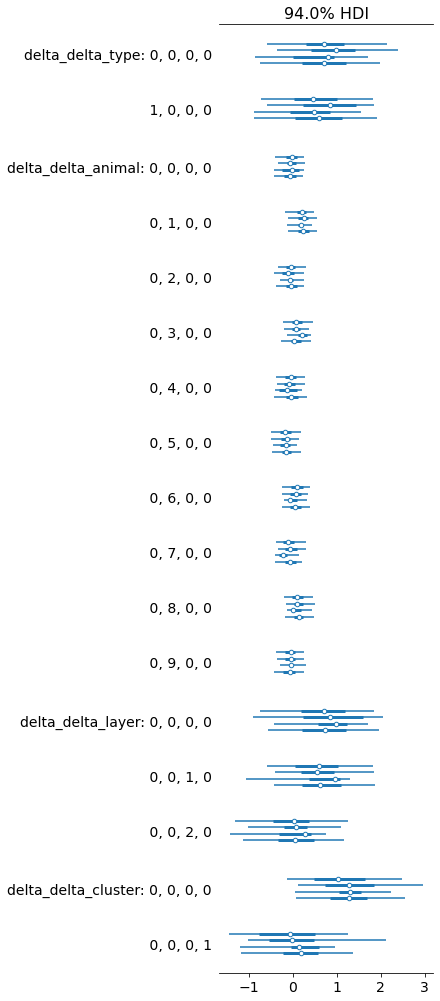

In [11]:
az.plot_forest(trace,var_names=['nu_max'])
az.plot_forest(trace,var_names=['gamma_base'])
az.plot_forest(trace,var_names=['^delta_gamma'], filter_vars='regex')
az.plot_forest(trace,var_names=['delta_base'])
az.plot_forest(trace,var_names=['^delta_delta'], filter_vars='regex')


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

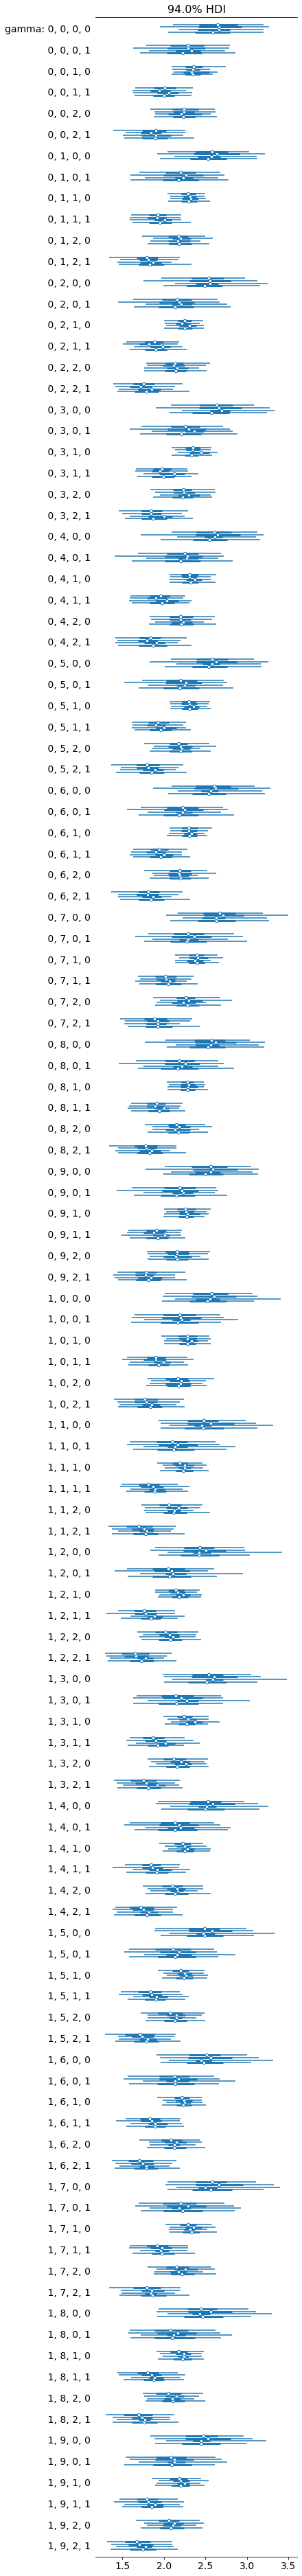

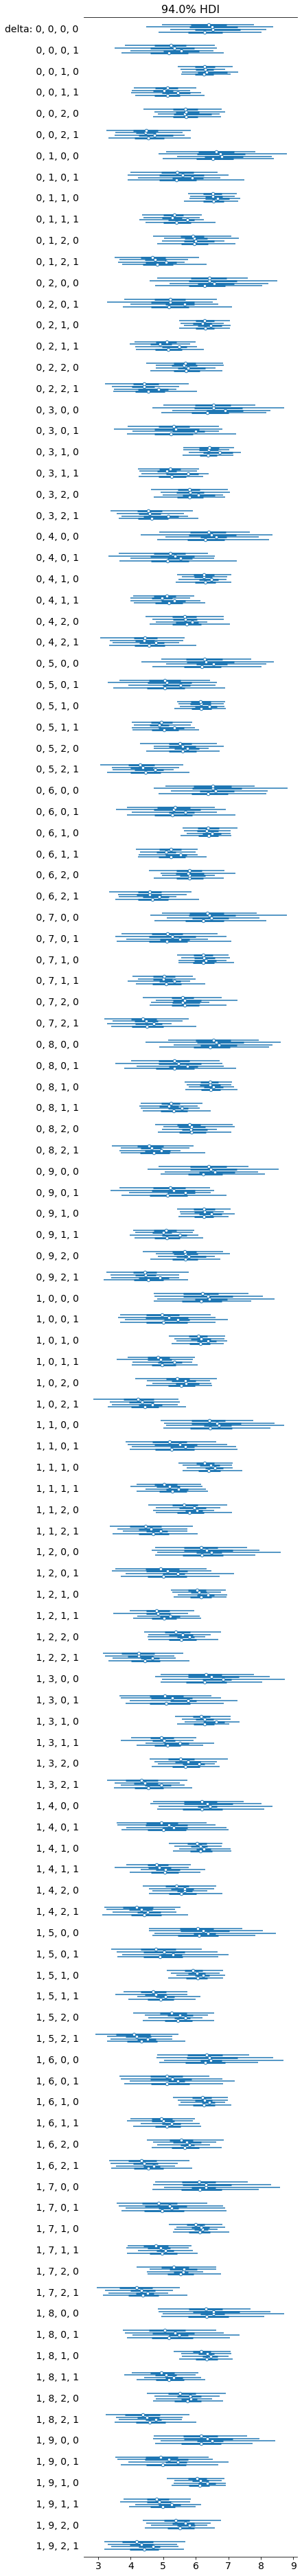

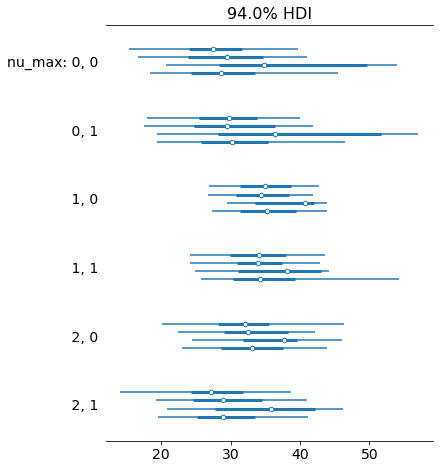

In [12]:
az.plot_forest(trace,var_names=['gamma'])
az.plot_forest(trace,var_names=['delta'])
az.plot_forest(trace,var_names=['nu_max'])

In [104]:
total_gamma = trace.posterior['gamma_base'].mean(axis=1) + \
    trace.posterior['delta_gamma_animal'].mean(axis=1) + \
    trace.posterior['delta_gamma_cluster'].mean(axis=1) + \
    trace.posterior['delta_gamma_layer'].mean(axis=1)
total_gamma.shape

(4, 4, 1, 1, 1, 1, 1, 1, 1, 1)

/tmp/ipykernel_19669/3087850351.py:7: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


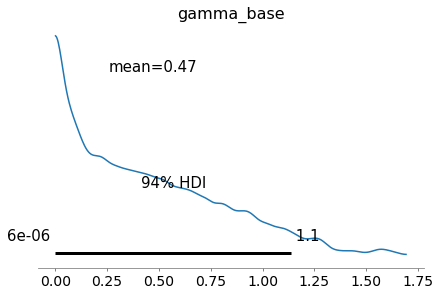

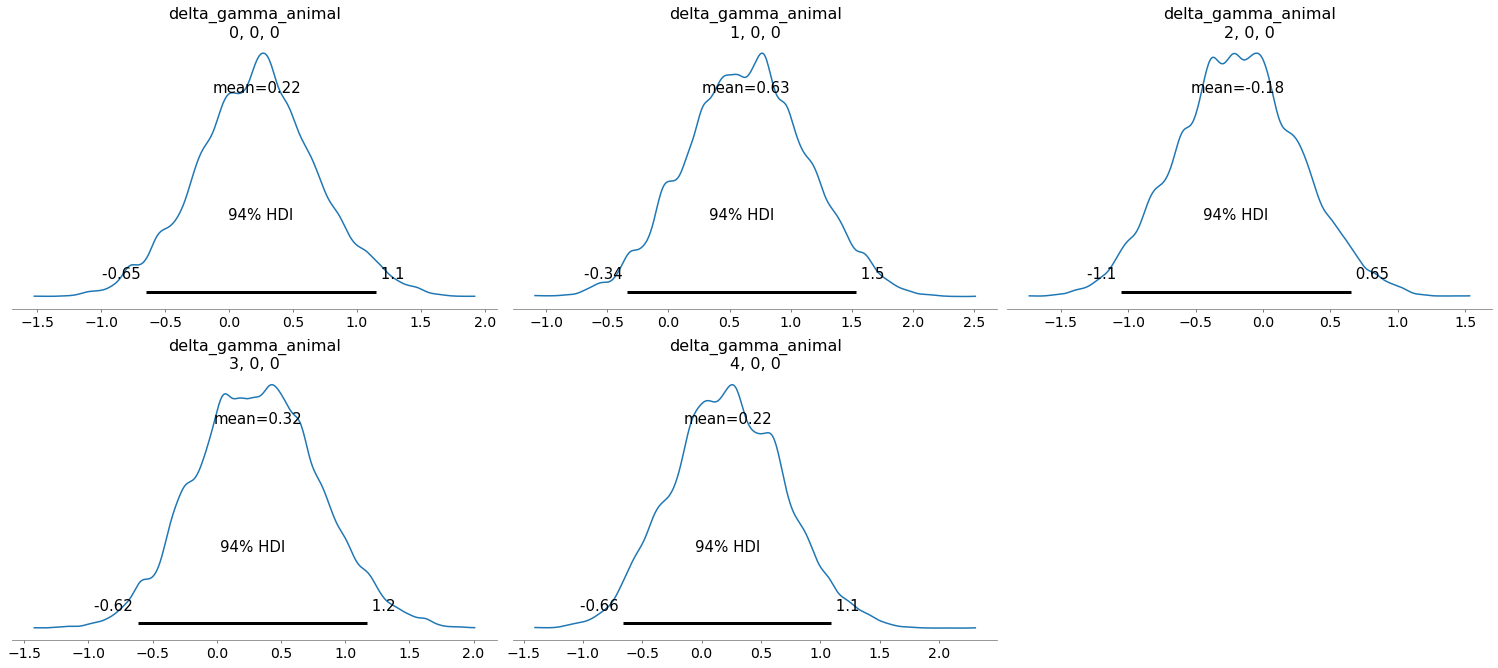

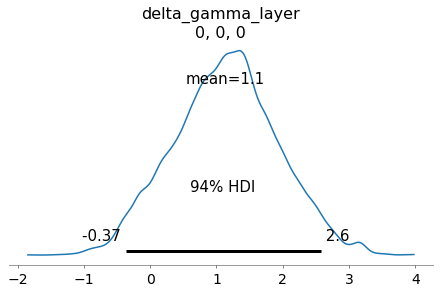

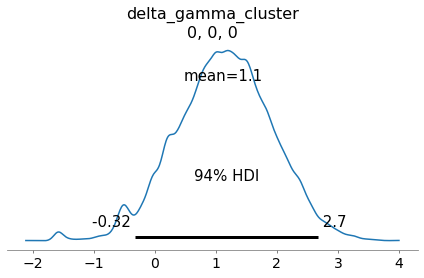

In [76]:
varName = 'gamma'
#az.plot_posterior(trace,var_names=[f'{varName}'])
az.plot_posterior(trace,var_names=[f'{varName}_base'],filter_vars='regex')
az.plot_posterior(trace,var_names=[f'{varName}_animal'],filter_vars='regex')
az.plot_posterior(trace,var_names=[f'{varName}_layer'],filter_vars='regex')
az.plot_posterior(trace,var_names=[f'{varName}_cluster'],filter_vars='regex')
plt.tight_layout()

In [77]:
with model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"delta_gamma_animal[0,0,0]",0.22,0.47,-0.65,1.15,0.01,0.01,1295.87,1115.14,1.00
"delta_gamma_animal[1,0,0]",0.63,0.49,-0.34,1.53,0.01,0.01,1235.11,1769.29,1.00
"delta_gamma_animal[2,0,0]",-0.18,0.45,-1.05,0.65,0.01,0.01,1216.28,1714.81,1.00
"delta_gamma_animal[3,0,0]",0.32,0.48,-0.62,1.17,0.01,0.01,1257.36,1174.28,1.00
"delta_gamma_animal[4,0,0]",0.22,0.47,-0.66,1.09,0.01,0.01,1321.07,2479.00,1.00
"delta_gamma_layer[0,0,0]",1.14,0.79,-0.37,2.57,0.02,0.02,1360.78,1153.70,1.00
"delta_gamma_cluster[0,0,0]",1.13,0.80,-0.32,2.67,0.02,0.02,1318.56,719.41,1.00
"delta_delta_animal[0,0,0]",-0.09,0.69,-1.44,1.15,0.02,0.01,1489.19,1099.25,1.00
"delta_delta_animal[1,0,0]",1.79,0.79,0.27,3.25,0.01,0.01,2900.27,3322.01,1.00
"delta_delta_animal[2,0,0]",-1.13,0.59,-2.18,0.02,0.01,0.01,2120.97,4416.05,1.00


In [78]:
model.deterministics

[sigma_gamma ~ HalfNormal,
 gamma_base ~ HalfNormal,
 gamma ~ Deterministic,
 sigma_delta ~ HalfNormal,
 delta_base ~ HalfNormal,
 delta ~ Deterministic]

(array([431., 126., 129.,  90.,  62.,  49.,  30.,  28.,  20.,   9.,  15.,
          5.,  13.,   8.,   4.,   5.,   3.,   4.,   1.,   4.,   1.,   1.,
          0.,   3.,   1.,   5.,   1.,   2.,   2.,   1.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
         4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
         8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. ]),
 <BarContainer object of 30 artists>)

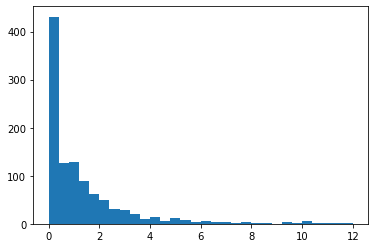

In [110]:
plt.hist(mP.spikes,np.linspace(0,12,31))